# Step 1: Install libraries


In [1]:
!pip install nltk
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy

!pip install pymongo


# Step 2: Import libraries

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo


# Step 3: Load Data

In [4]:

client = pymongo.MongoClient('mongodb://localhost:27017')
db = client["AA"]
collection = db["db_airbnb"]
dataset = list(collection.find())
first_data = ""

if len(dataset) > 0:
    first_data = dataset[0]
    print(first_data)
else:
    print("No data found in the dataset.")

{'_id': '10009999', 'listing_url': 'https://www.airbnb.com/rooms/10009999', 'name': 'Horto flat with small garden', 'summary': 'One bedroom + sofa-bed in quiet and bucolic neighbourhood right next to the Botanical Garden. Small garden, outside shower, well equipped kitchen and bathroom with shower and tub. Easy for transport with many restaurants and basic facilities in the area.', 'space': 'Lovely one bedroom + sofa-bed in the living room, perfect for two but fits up to four comfortably.  There´s a small outside garden with a shower There´s a well equipped open kitchen with both 110V / 220V wall plugs and one bathroom with shower, tub and even a sauna machine! All newly refurbished!', 'description': 'One bedroom + sofa-bed in quiet and bucolic neighbourhood right next to the Botanical Garden. Small garden, outside shower, well equipped kitchen and bathroom with shower and tub. Easy for transport with many restaurants and basic facilities in the area. Lovely one bedroom + sofa-bed in t

# Step 4: Data Preprocessing

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import pymongo

def preprocess_text(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    
    # Remove stopwords and punctuation from each sentence
    stop_words = set(stopwords.words('english'))
    vectorizer = CountVectorizer(stop_words=stop_words)
    
    preprocessed_sentences = []
    for sentence in sentences:
        sentence = sentence.lower()  # Convert to lowercase
        sentence = vectorizer.build_tokenizer()(sentence)  # Tokenize the sentence
        sentence = [word for word in sentence if word.isalpha()]  # Remove punctuation
        sentence = [word for word in sentence if word not in stop_words]  # Remove stopwords
        
        preprocessed_sentences.append(' '.join(sentence))
    
    return preprocessed_sentences

def summarize_text(text):
    # Preprocess the text
    preprocessed_sentences = preprocess_text(text)
    
    # Concatenate the preprocessed sentences into a single string
    preprocessed_text = ' '.join(preprocessed_sentences)
    
    # Perform text summarization
    word_frequencies = {}
    for word in preprocessed_text.split():
        if word not in word_frequencies:
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1
    
    max_frequency = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] /= max_frequency
    
    sentence_scores = {}
    for sentence in preprocessed_sentences:
        for word in sentence.split():
            if word in word_frequencies.keys():
                if sentence not in sentence_scores:
                    sentence_scores[sentence] = word_frequencies[word]
                else:
                    sentence_scores[sentence] += word_frequencies[word]
    
    summary_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)[:3]
    summary = ' '.join(summary_sentences)
    
    return summary


# Example usage
first_data = dataset[0]
summary = summarize_text(first_data['summary'])
print(summary)


small garden outside shower well equipped kitchen bathroom shower tub one bedroom sofa bed quiet bucolic neighbourhood right next botanical garden easy transport many restaurants basic facilities area


# Step 5: Sentiment Analysis

In [15]:

from textblob import TextBlob


# Connect to MongoDB and retrieve the data
client = pymongo.MongoClient('mongodb://localhost:27017')
db = client["AA"]
collection = db["db_airbnb"]
dataset = list(collection.find())

# Preprocess summaries and perform sentiment analysis
processed_summaries = []
sentiments = []
sentiment_labels = []

for data in dataset:
    summary = data['summary']
    
    # Perform text preprocessing if needed
    processed_summary = preprocess_text(summary)  # Modify the preprocess_text function according to your needs
    processed_summaries.append(processed_summary)
    
    # Perform sentiment analysis
    blob = TextBlob(summary)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)
    
    # Assign sentiment labels
    if sentiment > 0:
        sentiment_labels.append("Positive")
    elif sentiment < 0:
        sentiment_labels.append("Negative")
    else:
        sentiment_labels.append("Neutral")

# Create a DataFrame with summary and sentiment information
data = {"summary": processed_summaries, "Sentiment": sentiment_labels}
df = pd.DataFrame(data)

# Display the tail of the DataFrame
print(df.tail())


                                                summary Sentiment
5550  [relax hawaiian style gated community oceanfro...  Positive
5551  [unique loft apartment frida kahlo decoration ...  Positive
5552  [renovated fully equipped within walking dista...  Positive
5553  [excellent private suite bathroom apart hotel ...  Positive
5554                           [modern convenient room]  Positive


# Step 6: Analyze the sentiment score

In [13]:
# Analyze the sentiment scores
positive_count = sum(sentiment > 0 for sentiment in sentiments)
negative_count = sum(sentiment < 0 for sentiment in sentiments)
neutral_count = len(sentiments) - positive_count - negative_count

# Print the sentiment analysis results
print("Positive Feedback Count:", positive_count)
print("Negative Feedback Count:", negative_count)
print("Neutral Feedback Count:", neutral_count)

Positive Feedback Count: 4103
Negative Feedback Count: 185
Neutral Feedback Count: 1267


# Step 7: Visualization

## Sentiment Distribution

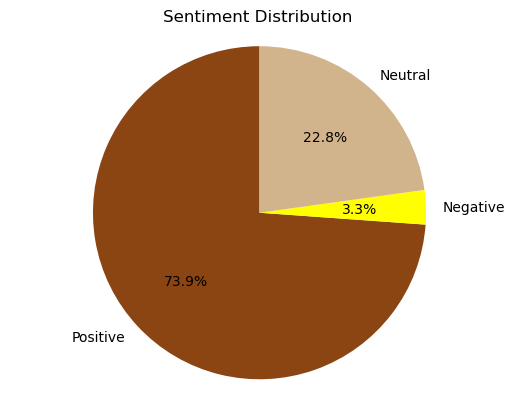

In [14]:
import matplotlib.pyplot as plt

# Sentiment counts and labels
labels = ['Positive', 'Negative', 'Neutral']
counts = [positive_count, negative_count, neutral_count]

# Colors for the pie chart
colors = ['#8B4513', '#FFFF00', '#d2b48c']

# Plotting the pie chart
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Setting the title and making the chart aspect ratio equal
plt.title('Sentiment Distribution')
plt.axis('equal')

# Display the pie chart
plt.show()


## Word Cloud

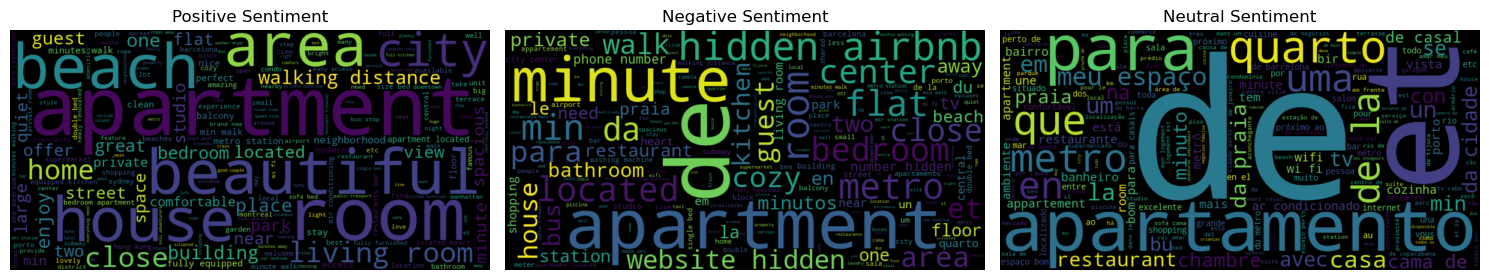

In [20]:
# Positive, negative, and neutral summaries
positive_summaries = [summary for summary, sentiment in zip(processed_summaries, sentiments) if sentiment > 0]
negative_summaries = [summary for summary, sentiment in zip(processed_summaries, sentiments) if sentiment < 0]
neutral_summaries = [summary for summary, sentiment in zip(processed_summaries, sentiments) if sentiment == 0]

# Flatten the nested lists
positive_combined_summary = ' '.join([summary for sublist in positive_summaries for summary in sublist])
negative_combined_summary = ' '.join([summary for sublist in negative_summaries for summary in sublist])
neutral_combined_summary = ' '.join([summary for sublist in neutral_summaries for summary in sublist])



# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400).generate(positive_combined_summary)
negative_wordcloud = WordCloud(width=800, height=400).generate(negative_combined_summary)
neutral_wordcloud = WordCloud(width=800, height=400).generate(neutral_combined_summary)

# Plot the word clouds
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Sentiment')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Negative Sentiment')
axes[1].axis('off')

axes[2].imshow(neutral_wordcloud, interpolation='bilinear')
axes[2].set_title('Neutral Sentiment')
axes[2].axis('off')

plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22312\1807788827.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(top_positive_words, rotation=45)
C:\Users\user\AppData\Local\Temp\ipykernel_22312\1807788827.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(top_negative_words, rotation=45)
C:\Users\user\AppData\Local\Temp\ipykernel_22312\1807788827.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(top_neutral_words, rotation=45)


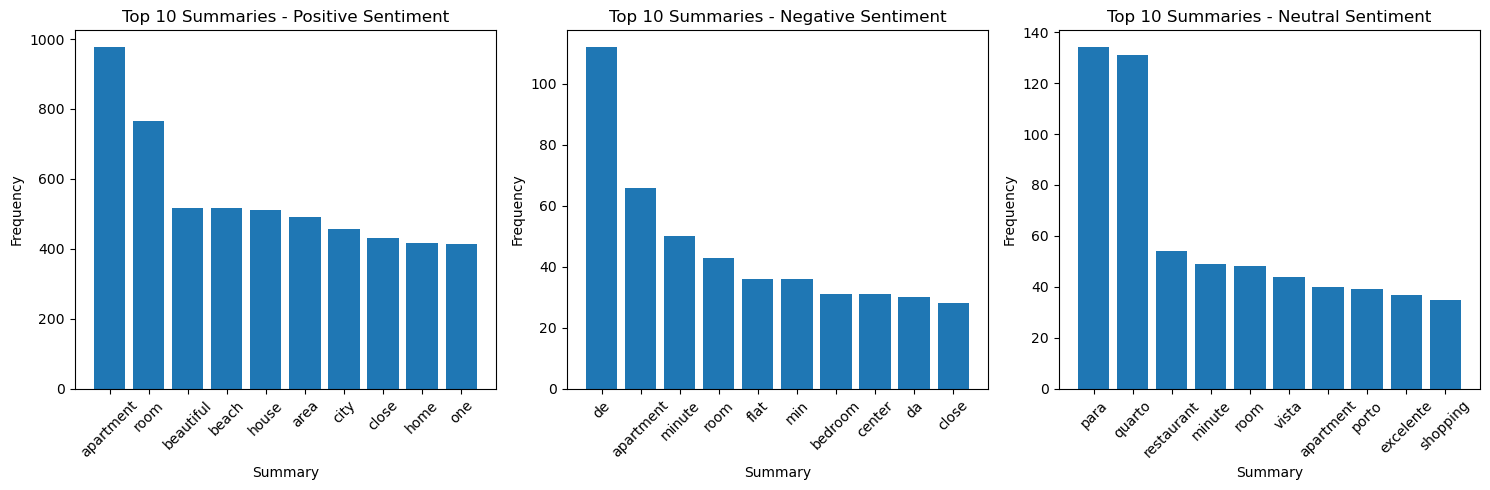

In [22]:
import nltk
from nltk.corpus import words

positive_word_freq = positive_wordcloud.process_text(positive_combined_summary)
negative_word_freq = negative_wordcloud.process_text(negative_combined_summary)
neutral_word_freq = neutral_wordcloud.process_text(neutral_combined_summary)

english_words = set(words.words())

def filter_valid_words(word_freq, min_length=1):
    valid_word_freq = {}
    for word, freq in word_freq.items():
        if word in english_words and len(word) > min_length:
            valid_word_freq[word] = freq
    return valid_word_freq

positive_valid_word_freq = filter_valid_words(positive_word_freq)
negative_valid_word_freq = filter_valid_words(negative_word_freq)
neutral_valid_word_freq = filter_valid_words(neutral_word_freq, min_length=3)

positive_sorted_word_freq = dict(sorted(positive_valid_word_freq.items(), key=lambda x: x[1], reverse=True))
negative_sorted_word_freq = dict(sorted(negative_valid_word_freq.items(), key=lambda x: x[1], reverse=True))
neutral_sorted_word_freq = dict(sorted(neutral_valid_word_freq.items(), key=lambda x: x[1], reverse=True))

top_positive_words = list(positive_sorted_word_freq.keys())[:10]
top_positive_freq = list(positive_sorted_word_freq.values())[:10]

top_negative_words = list(negative_sorted_word_freq.keys())[:10]
top_negative_freq = list(negative_sorted_word_freq.values())[:10]

top_neutral_words = list(neutral_sorted_word_freq.keys())[:10]
top_neutral_freq = list(neutral_sorted_word_freq.values())[:10]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Positive Sentiment
axes[0].bar(top_positive_words, top_positive_freq)
axes[0].set_title('Top 10 Summaries - Positive Sentiment')
axes[0].set_xlabel('Summary')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(top_positive_words, rotation=45)

# Negative Sentiment
axes[1].bar(top_negative_words, top_negative_freq)
axes[1].set_title('Top 10 Summaries - Negative Sentiment')
axes[1].set_xlabel('Summary')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(top_negative_words, rotation=45)

# Neutral Sentiment
axes[2].bar(top_neutral_words, top_neutral_freq)
axes[2].set_title('Top 10 Summaries - Neutral Sentiment')
axes[2].set_xlabel('Summary')
axes[2].set_ylabel('Frequency')
axes[2].set_xticklabels(top_neutral_words, rotation=45)

plt.tight_layout()
plt.show()
